In [6]:
import os
from datetime import datetime, date
from sklearn import utils
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

### Preprocessor
---------------------

In [138]:
class Preprocessor:
    def _fit_transform(self, raw):
        result = raw.copy()

        result = self._n_comment_to_float(result)
        result = self._str_to_datetype(result)
        result = self._add_n_hashtag(result)
        
        non_numeric = ['channel', 'title', 'genre', 'description', 'date', 'sign_in']
        
        result = self._merge(result, non_numeric)
        result = self._add_sub_diff(result)
        result = self._add_no_upload_interval(result)
        result = self._remove_nan(result, non_numeric)

        return result
        
        
    #FEATRUES TO ADD & MODIFY
    ####################################################################
    def _n_comment_to_float(self,result):
        idx1 = result['n_comment'] == '댓글 사용 중지'
        idx2 = result.n_comment.isna()
        idx = idx1|idx2
        result['n_comment'].loc[idx] = result['n_comment'].loc[idx].apply(lambda x: 0)
        result['n_comment'] = result['n_comment'].astype(float)
        return result
        
        
    def _str_to_datetype(self,result):
        #csv파일 로드시 date 컬럼이 str 타입으로 읽혀진 경우 이를 datetype으로 변환
        if pd.api.types.is_datetime64_ns_dtype(result['date']):
            pass
        else:
            result['date'] = pd.to_datetime(result['date'])
        return result
    
    
    def _add_n_hashtag(self,result):
        result['n_hashtage'] = 0
        idx = result['description'].notnull()
        result.loc[idx, 'n_hashtage'] = result.loc[idx, 'description'].apply(lambda x: len(x.split('#'))-1)
        return result
    
    
    @staticmethod
    def _get_to_merge(data, numeric, non_numeric):
        data.reset_index(drop=True)
        num_to_add = data.title.shape[0] - data.title.isna().sum()
        data = pd.concat((data[non_numeric].iloc[0,:], data[numeric].mean()))
        data['video_num'] = num_to_add
        return data
    def _merge(self, result, non_numeric):
        #operates both merge and creating video_num featrue
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        return result.groupby(['channel', 'date']).apply(lambda x: self._get_to_merge(x, numeric, non_numeric)).reset_index(drop=True)
    
    
    @staticmethod
    def _get_sub_diff(result):
        result = result.reset_index(drop=True)
        result['sub_diff'] = (result['cumul_subs'] - result['cumul_subs'].shift())
        return result
    def _add_sub_diff(self,result):
        result = result.groupby('channel').apply(lambda x: self._get_sub_diff(x)).reset_index(drop=True)
        result.loc[result.sub_diff.isna(), 'sub_diff'] = 0
        return result
    
    
    @staticmethod
    def _get_no_upload_interval(result):
        result = result.reset_index(drop=True)
        upload_idx = result[result['video_num'] != 0].index.tolist()
        temp = [0 for i in range(result.shape[0])]
        for i in range(len(upload_idx)):
            if i == len(upload_idx)-1:
                former = upload_idx[i]
                temp[former+1:] = [i+1 for i in range(len(temp[former+1:]))]
            else:
                former, latter = upload_idx[i], upload_idx[i+1]
                temp[former+1:latter] = [i+1 for i in range(len(temp[former+1:latter]))]
        result['no_upload_interval'] = temp
        return result
    def _add_no_upload_interval(self,result):
        return result.groupby('channel').apply(lambda x: self._get_no_upload_interval(x)).reset_index(drop=True)
    
    
    def _remove_nan(self, result, non_numeric):
        numeric = [col for col in result.columns.tolist() if col not in non_numeric]
        result.loc[:, numeric] = result.loc[:,numeric].fillna(0)
        return result
    ####################################################################
    
    
    
    #CREATE SEQUENTIAL DATA
    ####################################################################
    def _extract_at_least_filter(self, result, filter_size):
        #fillter_size 이상인 채널 추출하기
        alive_idx = result['channel'].value_counts() >= filter_size
        alive_array = alive_idx[alive_idx==True].index
        return result[result['channel'].isin(alive_array)].reset_index(drop=True)
    
    
    @staticmethod
    def _to_sequential(result, filter_size, target_size, stride, drop_features, target_features):
        result = result.reset_index(drop=True)
        idx_list = result.index.tolist()
        
        train, target = [],[]
        for i in range((len(idx_list)-filter_size-target_size)//stride +1):
            train_idx = idx_list[i*stride : i*stride + filter_size]
            target_idx = idx_list[i*stride + filter_size : i*stride + filter_size + target_size]
            train_temp = result.loc[train_idx,:].values.reshape(1,-1)
            target_temp = result.loc[target_idx,target_features].values.reshape(1,-1)
            
            train = train_temp.copy() if i == 0 else np.vstack([train, train_temp])
            target = target_temp.copy() if i == 0 else np.vstack([target, target_temp])
            
        train = pd.DataFrame(train, columns = result.columns.tolist()*filter_size)
        target = pd.DataFrame(target, columns = target_features*target_size)
        return train.drop(drop_features, axis=1), target
    def _create_sequential_data(self, result, filter_size=7, target_size=1, stride=1, drop_features=None, target_features=None):
        #remove channels with few information with respect to filter_size and target_size to extract
        result = self._extract_at_least_filter(result, filter_size + target_size)
        
        #drop_features: features to drop fromf X (features)
        #target_features: features to extract from Y (targets)
        if drop_features is None:
            drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs']
        if target_features is None:
            target_features = ['sub_diff']
        
        #return train, target set wrt groups
        result = result.groupby('channel').apply(lambda x: self._to_sequential(x, filter_size, target_size, stride, drop_features, target_features)).reset_index(drop=True)
        return self._combine(result)
    
    
    def _combine(self, result):
        temp0, temp1 = [], []
        for i in range(len(result)):
            temp0.append(result[i][0])
            temp1.append(result[i][1])
        temp0 = pd.concat(temp0)
        temp1 = pd.concat(temp1)
        return (temp0, temp1)
    ####################################################################


    
    #SCALE
    ####################################################################
    def scale(self, data, return_original_scale=True):
        original_scale = pd.concat((data.max(), data.min()), axis=1).T
        original_scale.index=['max', 'min']
        scaler = preprocessing.MinMaxScaler()
        data = pd.DataFrame(scaler.fit_transform(data), columns=data.columns)
        if return_original_scale:
            return data, original_scale
        return data
    
        
    def inverse_scale(pred, scl):
        for idx in range(pred.shape[1]):
            minimum = scl.iloc[1,idx]
            maximum = scl.iloc[0,idx]
            original = pred.iloc[:,idx]
            pred.iloc[:,idx] = (maximum-minimum)*original + minimum

### Data Loader
-----------------

In [8]:
class DataLoader(Preprocessor):
    def __init__(self, path):
        self._raw = pd.read_csv(path)
        self.data = super()._fit_transform(self._raw.copy())
        print('Data Loaded. :P')
        
        
    def get_data(self, filter_size=7, target_size=1, stride=1, drop_features=None, target_features=None,
                         channel:list=None, shuffle=False, random_state=None, order=None):
        if channel==None:
            data_to_extract = self.data
        else:
            channels = self.list_channel[channel].tolist()
            data_to_extract = self.data.set_index('channel').loc[channels].reset_index()
            
        train, target = self._create_sequential_data(data_to_extract, filter_size, target_size, stride, drop_features, target_features)
        if shuffle:
            train, target = utils.shuffle(train, target, random_state=random_state)
        
        if order:
            train_col = [col for col in train.columns.unique().tolist()]
            target_col = [col for col in target.columns.unique().tolist()]
            train = train[train_col]
            target = target[target_col]
            
        return train, target
    
    
    @property
    def list_features(self):
        #list the entire features, hence you can choose which features are included in whole set.
        return self.data.columns.tolist()
    
    @property
    def list_channel(self):
        #list indices of channel.
        return pd.Series(self.data.channel.unique().tolist())

### Path
---------------

In [27]:
#lite_path = '/home/mskang/CapstoneUOS/raw/train_raw_LITE.csv'
full_path = '/home/mskang/CapstoneUOS/raw/meta_trend_data.csv'

###  <b>  How to Run </b>
---------------
1. Define DataLoader
```
loader = DataLoader(path)
```
<br>
2. Get Train and Target Data (also equivalent in case of test set)
```
train, target = loader.get_data(filter_size, target_size, stride, *args)
```
<br>

#### <b> How to Scale </b>
Scale in between 0 and 1
```
data, original_scale = loader.scale(data)
```

Inverse Scale
```
loader.inverse_scale(data, original_scale)
```
<br>

#### <b> Further Note </b>
If ```order``` in ```loader.get_data``` is not ```None type```, then the columns will be clustered up to the same features.

```shuffle``` can be done easily by putting ```shuffle=True```, default value is ```False```.

```loader.list_featrues``` will show entire features to refer when extracting train or test set.

```loader.list_channel``` will show entire channel name and each index altogether.

In [40]:
#train, label = loader.get_data(60,30,30, channel=[0,1,2,3,4])

In [39]:
#train

In [12]:
#train2, label2 = loader.get_data(60,30,30, channel=[0,1,2,3,4], order=True)

In [38]:
#train2

# Model

<b>Machine Learning Strategies for Time Series Forecasting (Bontempi et al.)</b>


1. Introduction
    - One-step forecasting(supervised learning)을 먼저 잘 해야 multi-step forecasting 가능

2. Forecasting and Modeling
    - Random 행동은 (자유도가 적은) 결정론적 system으로부터 생성 (deterministic chaos)
    - 다시 만들어진 상태들(reconstructed states)로 예측 가능
    - 다만, noise는 고려하지 않음 (Why? 결정론적 process로 정확하게 예측 가능하다는 것이 가정)
    - y = f(y_t-d, y_t-d-1, ..., y_t-d-n+1) + w(t) (Nonlinear Auto Regressive formulation)

3. ML Approaches to Model Time Dependencies
    - Supervised Learning Setting: 행렬
    - Instantiation with Local Learning: 추이
    - Lazy Learning: 비선형 -> 선형

4. Strategies for Multi-step Time Series Forecasting

<br><b>최적의 filter_size, target_size, var_len, tar_len은 각각 무엇일까?</b>

In [95]:
# 데이터 로드하기
filter_size=180
target_size=7
stride=1
drop_features = ['date', 'genre','title', 'channel', 'description',	'sign_in', 'current_cumul_view', 'current_n_video', 'current_cumul_subs',
                 'cumul_subs', 'cumul_view', 'n_like', 'n_dislike', 'video_num', 'n_hashtage', 'daily_n_view', 'no_upload_interval']
target_features = ['sub_diff']

data_train, data_label = loader.get_data(filter_size,
                                         target_size,
                                         stride, 
                                         drop_features=drop_features,
                                         target_features=target_features,
                                         order=True)
data_train, original_scale_train = loader.scale(data_train) 
data_label, original_scale_test = loader.scale(data_label) 

In [96]:
print(data_train.shape)
print(data_label.shape)

(3614, 720)
(3614, 7)


In [157]:
# 트레인, 테스트 나누기
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(data_train, data_label, test_size=0.3, random_state=7)
x_val, x_test, y_val, y_test = train_test_split(x_test, y_test, test_size=0.5, random_state=7)

x_train_copy = x_train.fillna(0).values.reshape(x_train.shape[0], x_train.shape[1], 1)
y_train_copy = y_train.fillna(0).values
x_val_copy = x_val.fillna(0).values.reshape(x_val.shape[0], x_val.shape[1], 1)
y_val_copy = y_val.fillna(0).values
x_test_copy = x_test.fillna(0).values.reshape(x_test.shape[0], x_test.shape[1], 1)
y_test_copy = y_test.fillna(0).values

In [98]:
print("x_train_copy's shape: ", x_train_copy.shape) 
print("y_train_copy's shape: ", y_train_copy.shape) 
print("x_val_copy's shape: ", x_val_copy.shape)
print("y_val_copy's shape: ", y_val_copy.shape)
print("x_test_copy's shape: ", x_test_copy.shape)
print("y_test_copy's shape: ", y_test_copy.shape)

x_train_copy's shape:  (2529, 720, 1)
y_train_copy's shape:  (2529, 7)
x_val_copy's shape:  (542, 720, 1)
y_val_copy's shape:  (542, 7)
x_test_copy's shape:  (543, 720, 1)
y_test_copy's shape:  (543, 7)


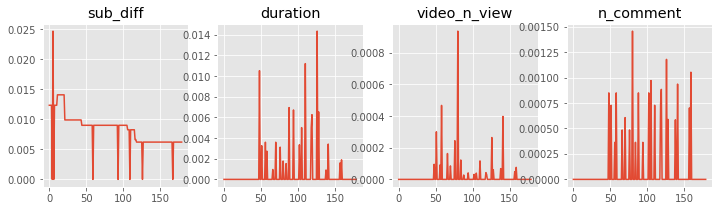

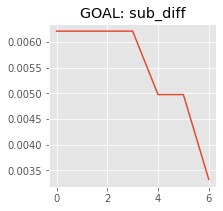

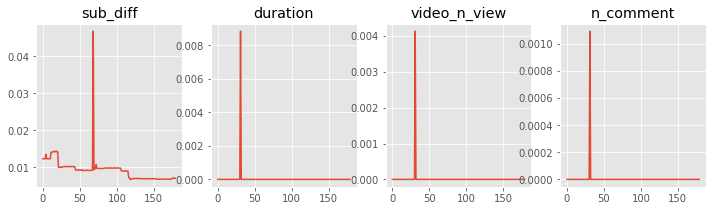

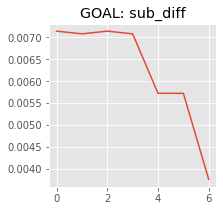

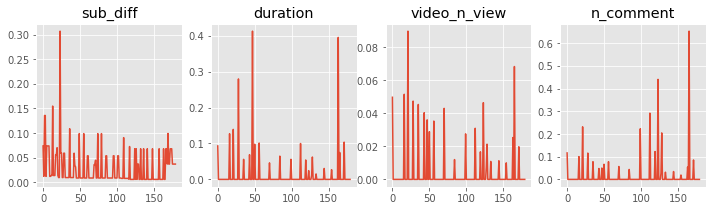

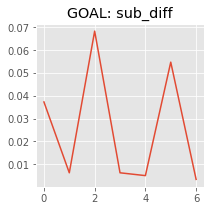

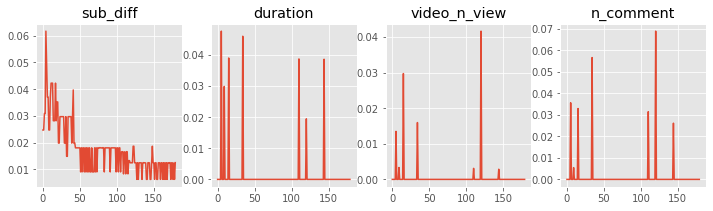

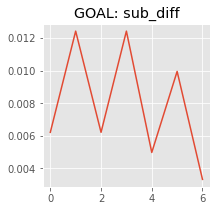

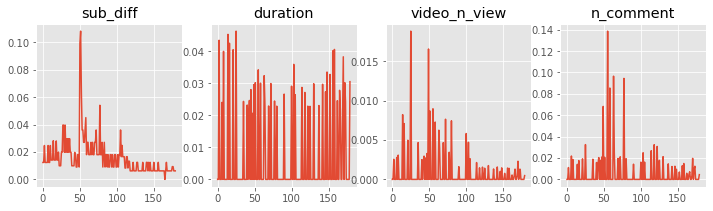

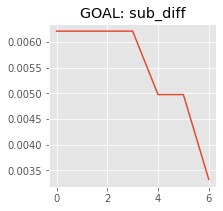

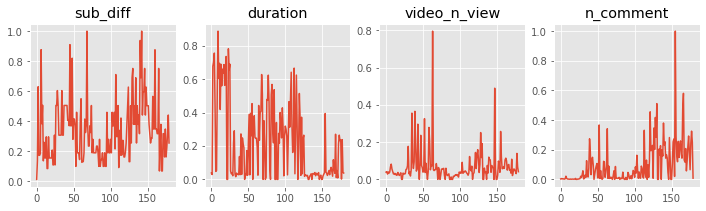

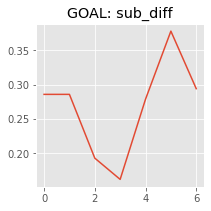

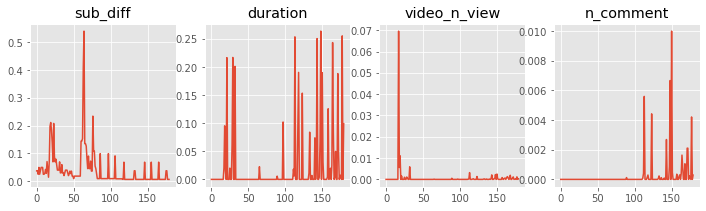

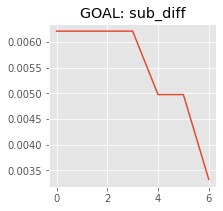

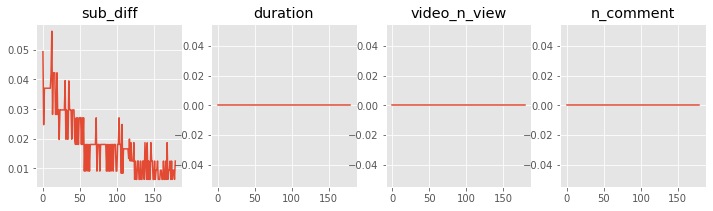

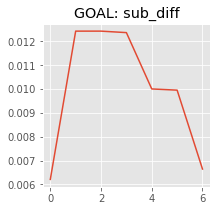

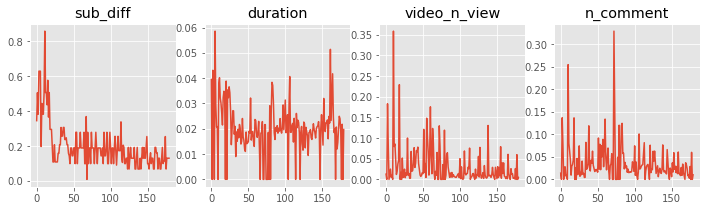

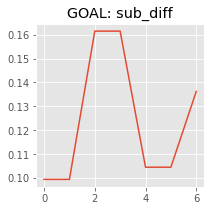

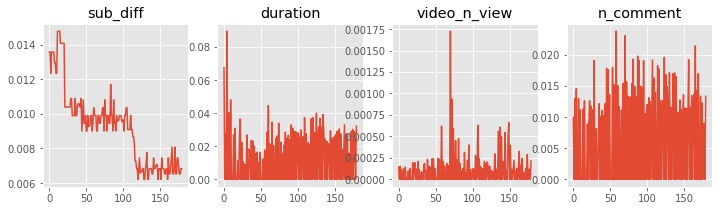

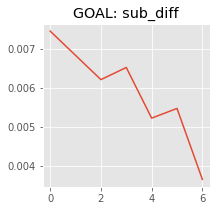

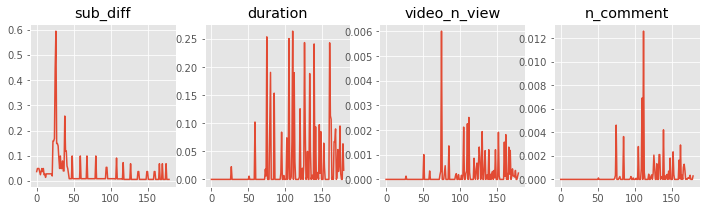

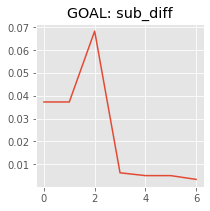

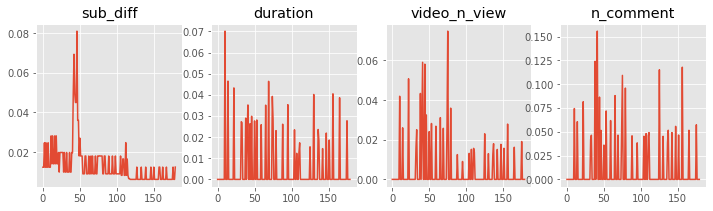

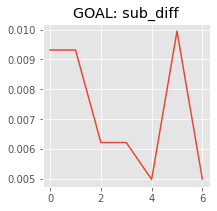

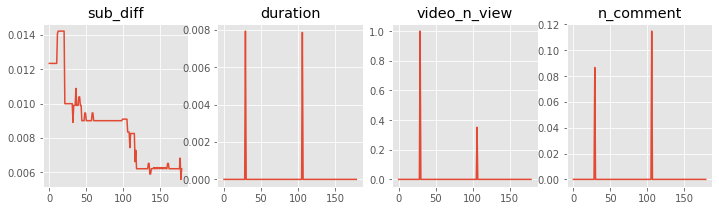

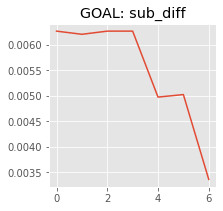

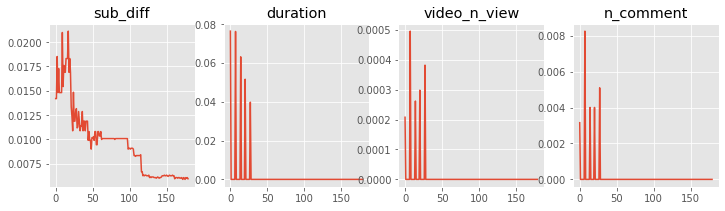

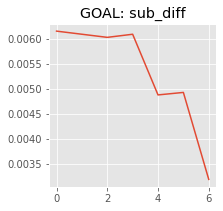

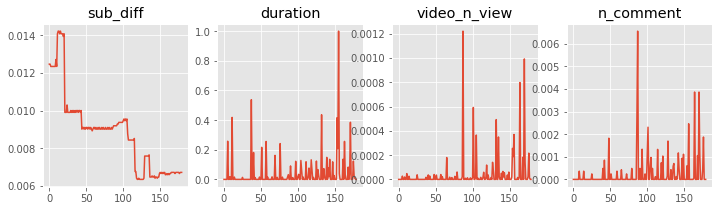

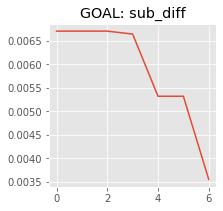

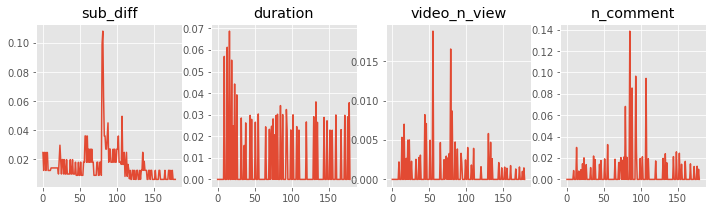

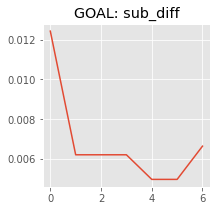

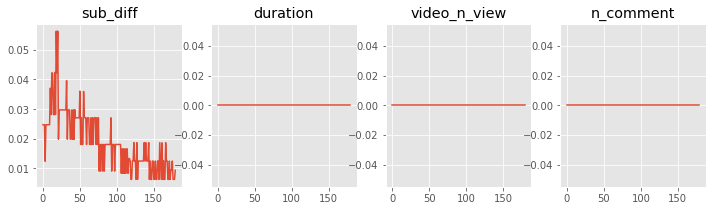

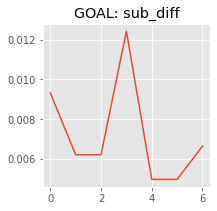

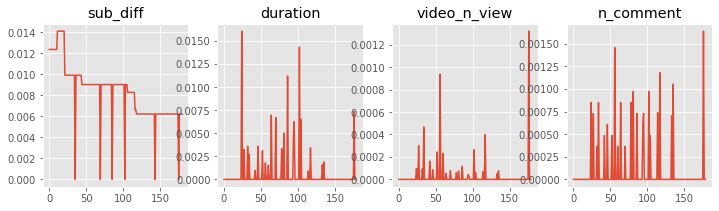

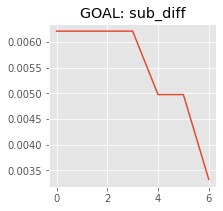

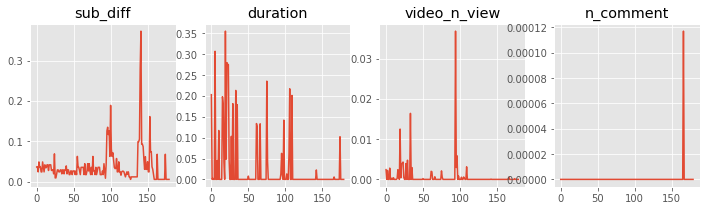

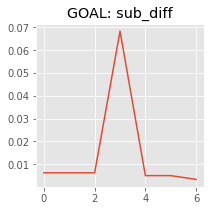

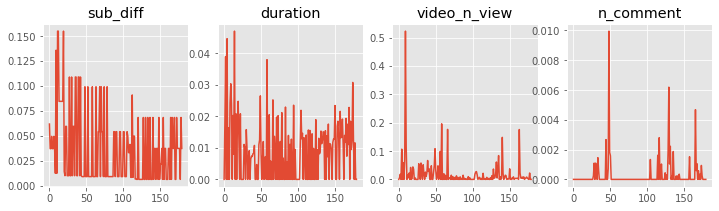

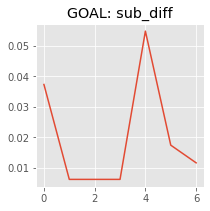

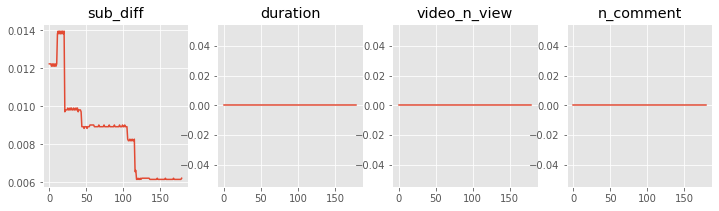

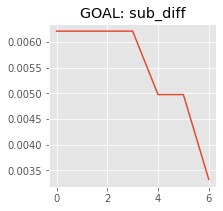

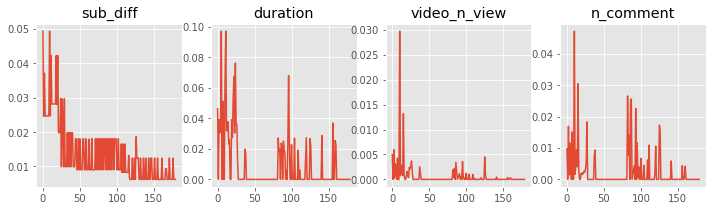

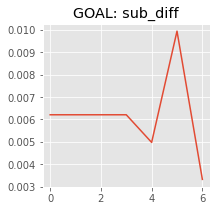

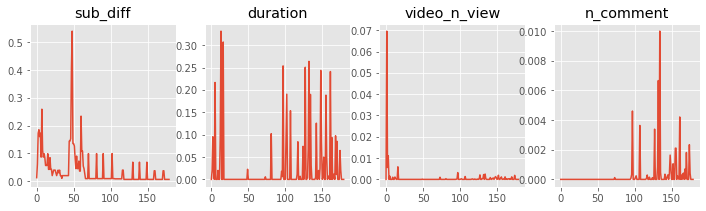

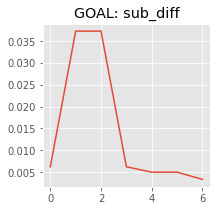

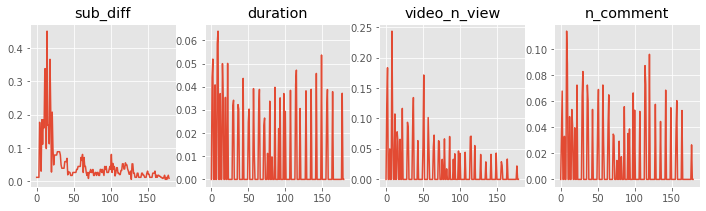

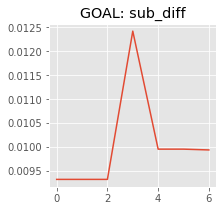

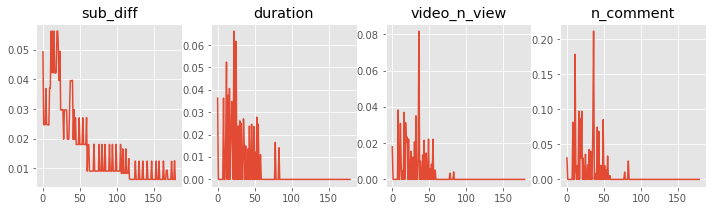

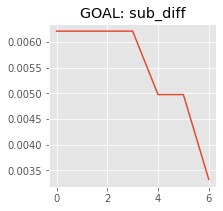

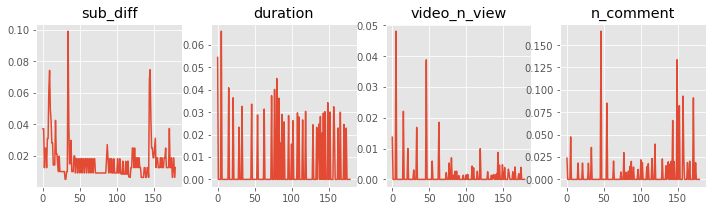

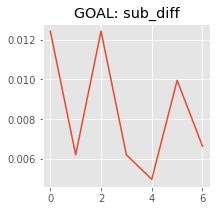

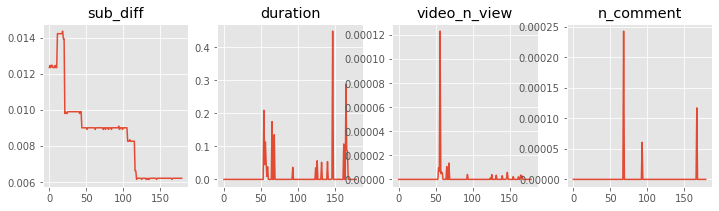

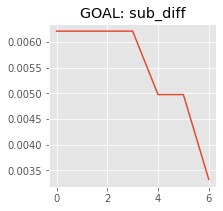

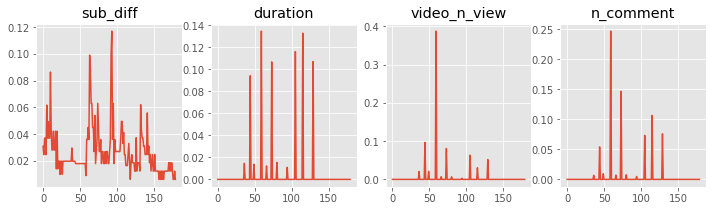

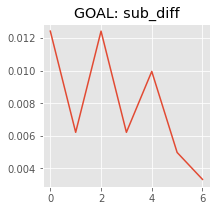

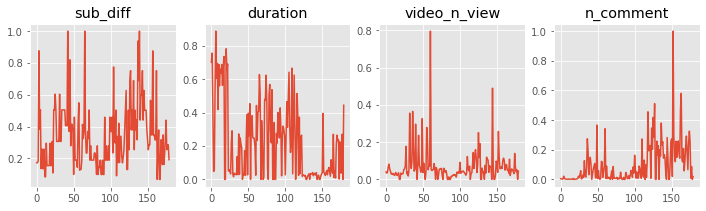

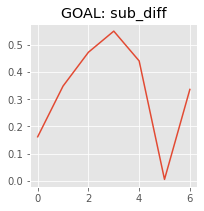

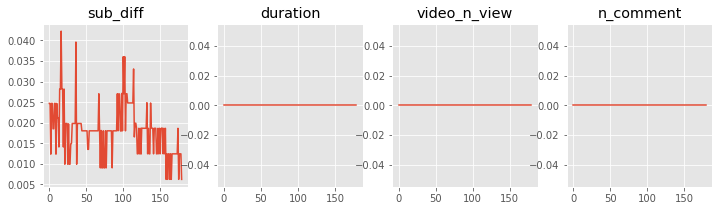

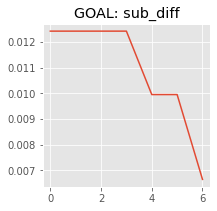

In [99]:
# 데이터 구성 살피기
import matplotlib.pyplot as plt

h = 3 # graph's height(length)

for n in range(30): # 1부터 x_train.shape[0]까지
    fig = plt.figure(figsize=(h*len(set(data_train.columns.tolist())), h))
    for i, train_var in enumerate(set(data_train.columns.tolist())):
        plt.subplot(1, len(set(data_train.columns.tolist())), i+1)
        plt.plot(x_train[train_var].iloc[n].values)
        plt.title(str(train_var))

    fig = plt.figure(figsize=(h*len(set(data_label.columns.tolist())), h))
    for i, label_var in enumerate(set(data_label.columns.tolist())):
        plt.subplot(1, len(set(data_label.columns.tolist())), i+1)
        plt.plot(y_train[label_var].iloc[n].values)
        plt.title("GOAL: " + str(label_var))
        
    plt.show()
    
# MAE가 최소 0.002보다는 작아야 함

In [110]:
# 텐서 슬라이스로 변형하기
import tensorflow as tf

BATCH_SIZE = 64

train_data = tf.data.Dataset.from_tensor_slices((x_train_copy, y_train_copy))
train_data = train_data.cache().batch(BATCH_SIZE).repeat()
val_data = tf.data.Dataset.from_tensor_slices((x_val_copy, y_val_copy))
val_data = val_data.cache().batch(BATCH_SIZE).repeat()

In [114]:
# 모델 만들기
import tensorflow as tf
from tensorflow.keras.optimizers import Adam, RMSprop

output_num = target_size

model = tf.keras.models.Sequential()
model.add(tf.keras.layers.LSTM(units=128,
                               return_sequences=True,
                               input_shape=(x_train_copy.shape[-2:])))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(2048)) # Dense layer 한 개 더 추가했을 때 더 좋음
model.add(tf.keras.layers.Dense(output_num))
model.compile(loss='mae',
              optimizer=Adam(lr=0.0001)) # if gradient norm > clipnorm,
# then clipped gradient = gradient * (clipnorm / gradient norm)
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 720, 128)          66560     
_________________________________________________________________
flatten_13 (Flatten)         (None, 92160)             0         
_________________________________________________________________
dense_34 (Dense)             (None, 2048)              188745728 
_________________________________________________________________
dense_35 (Dense)             (None, 7)                 14343     
Total params: 188,826,631
Trainable params: 188,826,631
Non-trainable params: 0
_________________________________________________________________


In [115]:
# 기록하기
import time

filename='rnn_60_7_1_checkpoint.h5'

callback_list = [tf.keras.callbacks.ModelCheckpoint(filepath='Checkpoint/{}'.format(filename),
                                                    monitor='val_loss',
                                                    verbose=1,
                                                    save_best_only=True,
                                                    mode='min'),
                 tf.keras.callbacks.TensorBoard(log_dir='TensorBoard/rnn_logs/{}'.format(time.asctime())),
                 tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  patience=5),
                 tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss',
                                                      factor=0.1,
                                                      min_lr=1e-6, 
                                                      patience=0)]

EPOCHS = 30

history2 = model.fit(train_data,
                     epochs=EPOCHS,
                     steps_per_epoch=x_train.shape[0] // BATCH_SIZE, # training samples / batch size
                     validation_data=val_data,
                     validation_steps=x_test.shape[0] // BATCH_SIZE, # validation samples / batch size
                     callbacks=callback_list) 

Epoch 1/30
39/39 [==============================] - ETA: 0s - loss: 0.0420
Epoch 00001: val_loss improved from inf to 0.02404, saving model to Checkpoint/rnn_60_7_1_checkpoint.h5
39/39 [==============================] - 33s 845ms/step - loss: 0.0420 - val_loss: 0.0240
Epoch 2/30
39/39 [==============================] - ETA: 0s - loss: 0.0205
Epoch 00002: val_loss improved from 0.02404 to 0.01636, saving model to Checkpoint/rnn_60_7_1_checkpoint.h5
39/39 [==============================] - 31s 789ms/step - loss: 0.0205 - val_loss: 0.0164
Epoch 3/30
39/39 [==============================] - ETA: 0s - loss: 0.0196
Epoch 00003: val_loss improved from 0.01636 to 0.01538, saving model to Checkpoint/rnn_60_7_1_checkpoint.h5
39/39 [==============================] - 33s 834ms/step - loss: 0.0196 - val_loss: 0.0154
Epoch 4/30
39/39 [==============================] - ETA: 0s - loss: 0.0182
Epoch 00004: val_loss did not improve from 0.01538
39/39 [==============================] - 28s 716ms/step - l

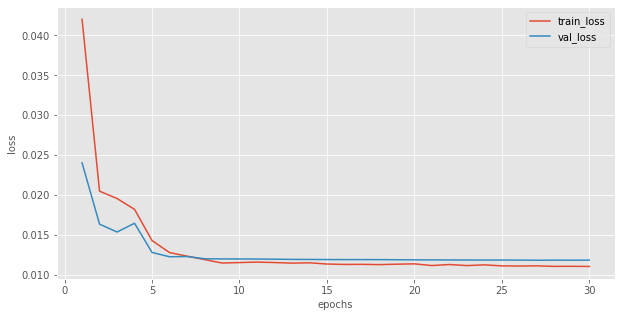

In [117]:
# 모델 성능 그래프로 나타내기
UPDATED_EPOCHS = 30 + 1

epochs = np.arange(1, UPDATED_EPOCHS)
fig, axes = plt.subplots(figsize=(10, 5))

plt.plot(epochs, history2.history['loss'], label='train_loss')
plt.plot(epochs, history2.history['val_loss'], label='val_loss')
plt.xlabel('epochs', fontdict={'size': 10})
plt.ylabel('loss', fontdict={'size': 10})
plt.legend()
plt.show()

In [118]:
# 모델 저장하고 복원하기

filename = 'rnn_model.h5'

model.save('Model/{}'.format(filename))
res_model = tf.keras.models.load_model('Model/{}'.format(filename))
res_model.load_weights('Model/{}'.format(filename))
res_model.evaluate(x_test_copy, y_test_copy)

17/17 [==============================] - 3s 154ms/step - loss: 0.0102


0.010222523473203182

In [119]:
# 테스트 세트로 예측하기
test_predict = model.predict(x_test_copy)

In [155]:
# inverse_scale 잘 작동 안 됨 ㅠㅠ 그래서 그냥 코드 직접 가지고 와서 실행함
#loader.inverse_scale(pred=data_label, scl=original_scale_test)
#for idx in range(data_train.shape[1]):
#    x_test.iloc[:,idx] = (original_scale_train.iloc[0,idx]-original_scale_train.iloc[1,idx])*x_test.iloc[:,idx]+original_scale_train.iloc[1,idx]


#for idx in range(data_label.shape[1]):
#    y_test_copy[:,idx] = (original_scale_test.iloc[0,idx]-original_scale_test.iloc[1,idx])*y_test_copy[:,idx]+original_scale_test.iloc[1,idx]

#for idx in range(data_label.shape[1]):
#    test_predict[:,idx] = (original_scale_test.iloc[0,idx]-original_scale_test.iloc[1,idx])*test_predict[:,idx]+original_scale_test.iloc[1,idx]

In [160]:
# 예측한 것 시각화하기

#n = x_train.shape[0]
n = 100 # 몇 개만
past_num = 180
future_num = output_num
w = past_num+future_num

for i in range(n):
    dates = [j for j in range(w)]
    fig, axes = plt.subplots(figsize=(8, 4))
    
    for label_var in set(data_label.columns.tolist()):
        plt.title(label_var, fontdict={'size': 20})
        plt.plot(dates[:past_num], x_test[label_var].iloc[i], 'k', label='past') # ?
        
    plt.plot(dates[past_num:], y_test_copy[i][:], 'g', marker='o', label='actual future') # y_test_scaled
    plt.plot(dates[past_num:], test_predict[i][:], 'r', marker='o', label='predicted future') # ?
    plt.xlabel('Time', fontdict={'size': 10})
    plt.legend()
    plt.show()

NameError: name 'd' is not defined

In [123]:
# 테스트 세트에서의 모델 성능 알아보기

diff = np.subtract(y_test_copy, test_predict)
sq = np.square(diff)
ab = np.abs(diff)
mse = np.mean(sq)
mae = np.mean(ab)

print("Test MSE: ", mse)
print("Test MAE: ", mae)

Test MSE:  0.0008894276729633924
Test MAE:  0.01022252433291358
